# Import packages.

In [2]:
import h5py
from torch.utils.data import DataLoader, sampler
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from src.data_handle import *
from src.visualizations import *
from src.unet import *
import torch.optim as optim 
from src.train import *
import numpy as np

# Load the CityScapes dataset.
Read the training data file and test data file. And print the keys of the groups.

In [3]:
path_train = "./data/driving_train_data.h5"
path_test = "./data/driving_test_data.h5"

train_file = h5py.File(path_train,"r")
test_file = h5py.File(path_test,"r")

print("train_file.keys:", train_file.keys())
print("test_file.keys:", test_file.keys())

train_file.keys: <KeysViewHDF5 ['color_codes', 'rgb', 'seg']>
test_file.keys: <KeysViewHDF5 ['color_codes', 'rgb', 'seg']>


In [4]:
color_codes = train_file['color_codes']
x_train = train_file['rgb']
y_train = train_file['seg']
x_test = test_file['rgb']
y_test = test_file['seg']
print("color_codes:", color_codes.shape)
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test", y_test.shape)

color_codes: (34, 3)
x_train: (2975, 128, 256, 3)
y_train: (2975, 128, 256, 1)
x_test: (500, 128, 256, 3)
y_test (500, 128, 256, 1)


Compute the mean and std of each channel for normalization.

In [5]:
mean = np.mean(x_train[:]/255, axis=(0,1,2))
std = np.std(x_train[:]/255, axis=(0,1,2))
print("mean:", mean)
print("std:", std)

mean: [0.2843752  0.32562288 0.28738835]
std: [0.18663006 0.1895946  0.18635758]


Load the dataset using data_loader implemented in src/data_handle.py.

In [6]:
transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
num_train = int(0.9 * x_train.shape[0])
bs = 4

# 'data_loader' is implemented in src/data_handle.py
dset_train = data_loader(path_train, transform)
dset_val = data_loader(path_train, transform)
dset_test = data_loader(path_test, transform)

loader_train = DataLoader(dset_train, 
              batch_size=bs, 
              sampler=sampler.SubsetRandomSampler(range(num_train))
              )
loader_val = DataLoader(dset_val, 
             batch_size=bs, 
             sampler=sampler.SubsetRandomSampler(range(num_train, len(x_train)))
             )
loader_test = DataLoader(dset_test, batch_size=bs, num_workers=2)

num_class = dset_train.num_class


Take a look at the actual images and segmentation results in one minibatch. At the same time, test the data_loader.

torch.Size([4, 128, 256])


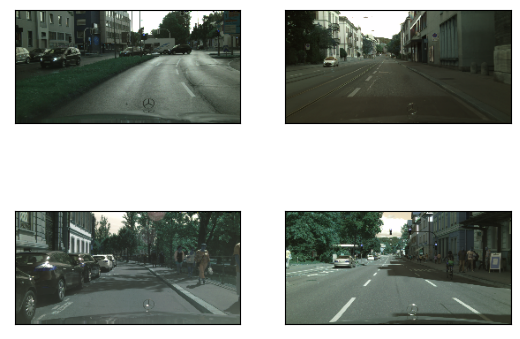

In [7]:
images, seg = next(iter(loader_train))
print(seg.shape)
images = images.numpy().transpose(0, 2, 3, 1)
images = ((images * std + mean) * 255).astype('uint8')
for i in range(bs):
    plt.subplot(2, 2, i+1)
    plt.xticks([])  
    plt.yticks([])
    plt.imshow(images[i])
plt.show()

# Define the model, loss function and optimizer.
Unet class is implemented in src/unet.py. The loss function is defined in the train() function. We use nn.CrossEntropyLoss() as the loss function and optim.Adam() as the optimizer.

In [8]:
# 'unet' is implemented in src/unet.py
model = unet(feature_scale=1, is_deconv=True, is_batchnorm=True)
optimizer = optim.Adam(model.parameters()) 

# Train the network.
Now train the model.

In [9]:
loss_history, train_acc_history,  val_acc_history = train(model, optimizer, loader_train, loader_val, epochs=2)
# save the well-trained model weights
torch.save(model.state_dict(), "Bayesian_Unet_Weights.pth")

(Epoch 0 / 100) train_acc = 3.3936%, val_acc = 3.0816%, train_miou = 0.0015, val_miou = 0.0015
(Iteration 100) loss = 1.2908
(Iteration 200) loss = 1.3806
(Iteration 300) loss = 1.1823
(Iteration 400) loss = 0.8479
(Iteration 500) loss = 0.8561
(Iteration 600) loss = 1.2946
(Epoch 1 / 100) train_acc = 72.9530%, val_acc = 74.1692%, train_miou = 0.1664, val_miou = 0.1658
(Iteration 100) loss = 1.5064
(Iteration 200) loss = 1.2787
(Iteration 300) loss = 1.1708
(Iteration 400) loss = 0.8820
(Iteration 500) loss = 0.7384
(Iteration 600) loss = 1.7092
(Epoch 2 / 100) train_acc = 74.6804%, val_acc = 75.5499%, train_miou = 0.1713, val_miou = 0.1681
(Iteration 100) loss = 0.8512
(Iteration 200) loss = 0.7640
(Iteration 300) loss = 0.6271
(Iteration 400) loss = 1.1015
(Iteration 500) loss = 0.8381
(Iteration 600) loss = 0.9685
(Epoch 3 / 100) train_acc = 78.6583%, val_acc = 80.6148%, train_miou = 0.2159, val_miou = 0.2158
(Iteration 100) loss = 0.8090
(Iteration 200) loss = 0.7276
(Iteration 300

## Plots
Plot the loss, training accuracy and validation accuracy during optimization to get insight into what's wrong.

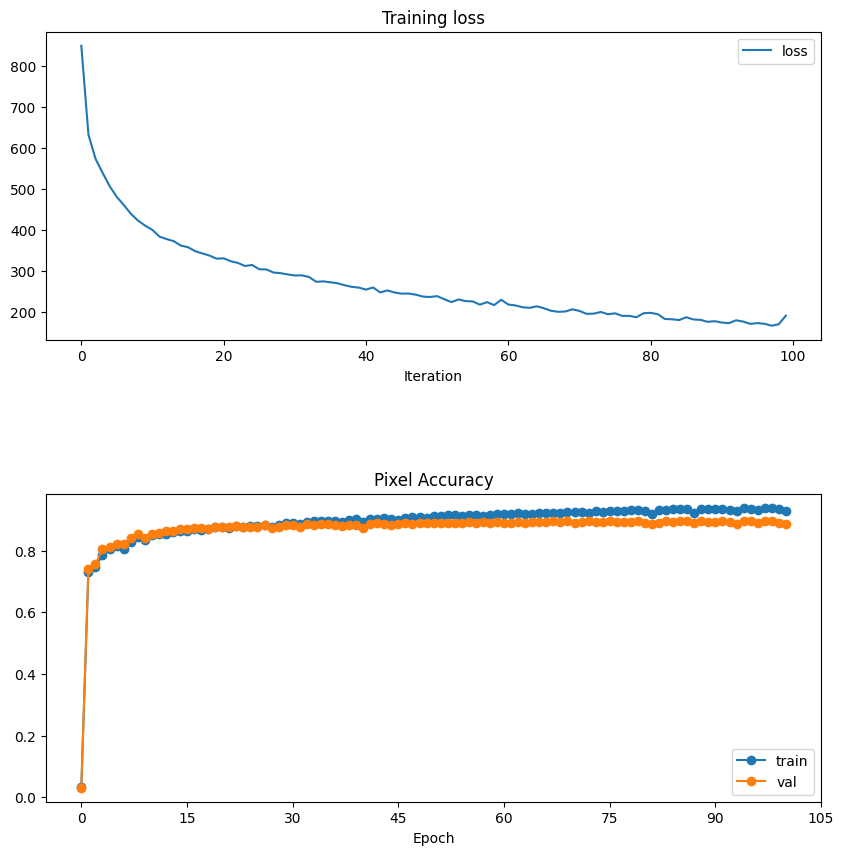

In [10]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.plot(loss_history, '-', label='loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history, '-o', label='train')
plt.plot(val_acc_history, '-o', label='val')
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(hspace=0.5)
plt.show()


Since it is difficult to see obvious difference between the train_accuracy and val_accuracy on the plot above, now I remove the accuracy before training (Epoch 0) to amplify y axis.

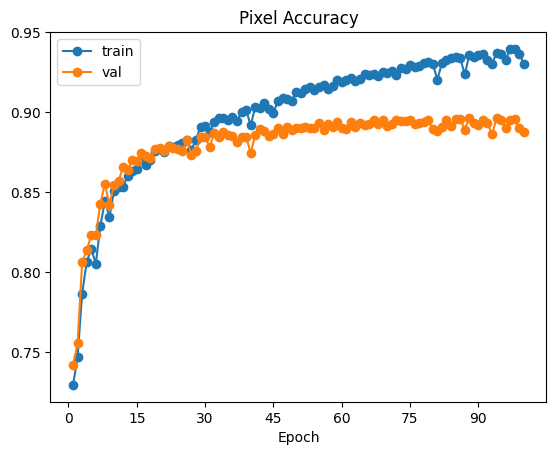

In [11]:
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.plot(list(range(1, len(train_acc_history))), train_acc_history[1:], '-o', label='train')
plt.plot(list(range(1, len(val_acc_history))), val_acc_history[1:], '-o', label='val')
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# Test
Test the model on an independent dataset.

In [12]:
# # load the pre-trained model weights
# model.load_state_dict(torch.load("Bayesian_Unet_Weights.pth"))
# model.to('cuda')

results = check_accuracy(loader_test, model.to('cuda'))
print('test accuracy: %.2f%% ' % (100 * results['acc']))
print('test MIOU: %.4f' % (results['miou']))

test accuracy: 87.76% 
test MIOU: 0.3661


Draw a bar chart showing the pixel accuracy across each semantic class. 

Text(0, 0.5, 'Pixel Accuracy')

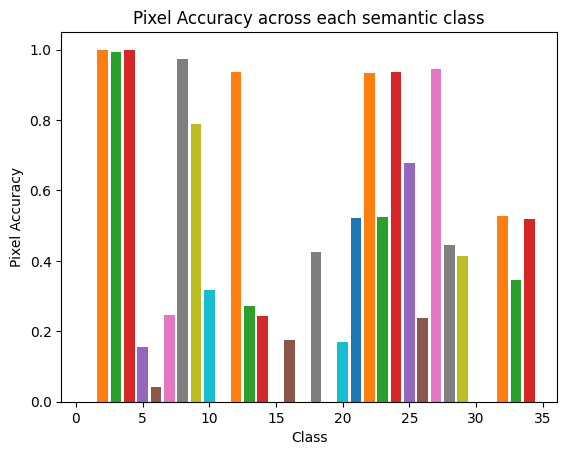

In [13]:
x_ordinate = np.arange(1, 35)

plt.rcParams["axes.unicode_minus"]=False

for i in range(len(x_ordinate)):
    plt.bar(x_ordinate[i],results['acc_cls'][i])
    
plt.title("Pixel Accuracy across each semantic class")
plt.xlabel("Class")
plt.ylabel("Pixel Accuracy")


Draw a bar chart showing the IOU across each semantic class.

Text(0, 0.5, 'IOU')

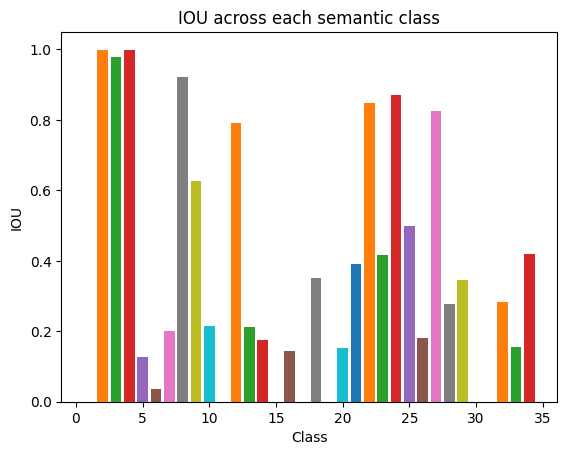

In [14]:
x_ordinate = np.arange(1, 35)

plt.rcParams["axes.unicode_minus"]=False

for i in range(len(x_ordinate)):
    plt.bar(x_ordinate[i],results['iou'][i])
    
plt.title("IOU across each semantic class")
plt.xlabel("Class")
plt.ylabel("IOU")


# Predictions and Visualizations for 5 different input examples.

In [15]:
bs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# randomly select 5 different input images in the test dataset
loader_test = DataLoader(dset_test, batch_size=bs, shuffle=True)

# predict and compute the mu, aleatoric uncertainty and episdemic uncertainty
imgs, trues = next(iter(loader_test))
imgs = imgs.to(device)
mu, aleatoric, episdemic = mu_alea_epis(model, imgs)

# format transformation
imgs = imgs.cpu().numpy().transpose(0, 2, 3, 1)
imgs = ((imgs * std + mean) * 255).astype('uint8')
mu = np.expand_dims(mu, axis=-1)
trues = np.expand_dims(trues, axis=-1)

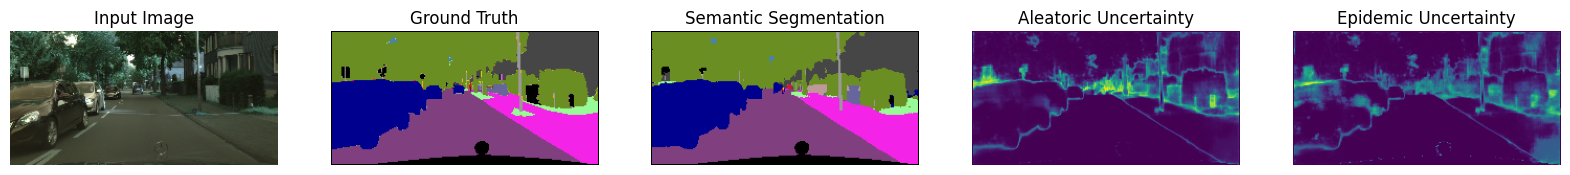

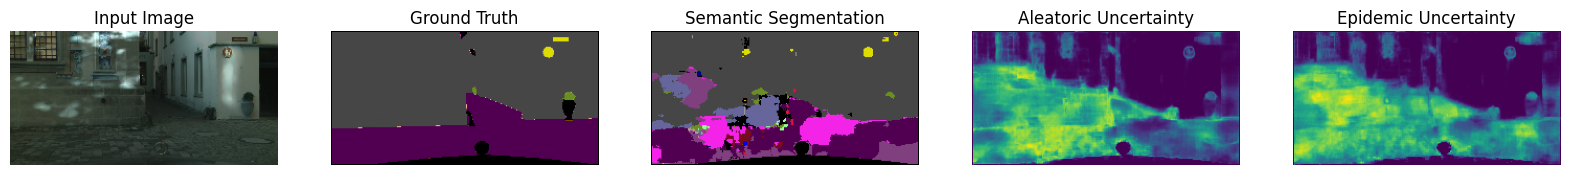

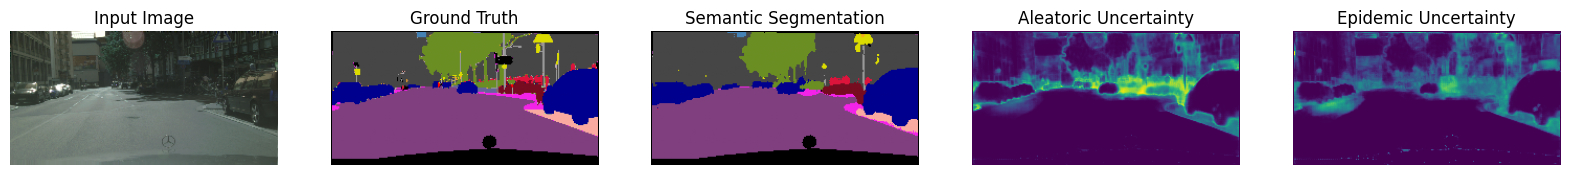

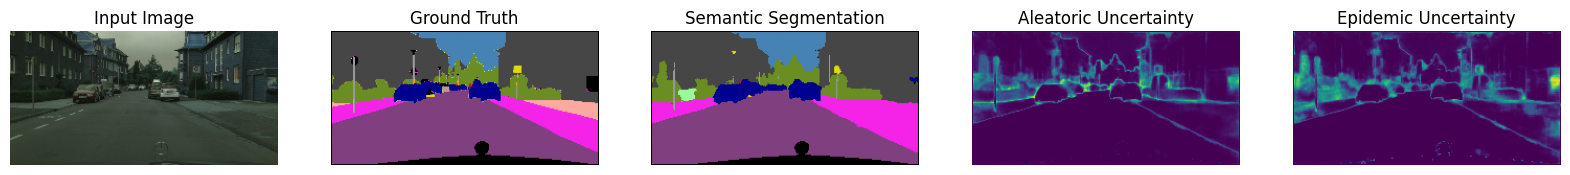

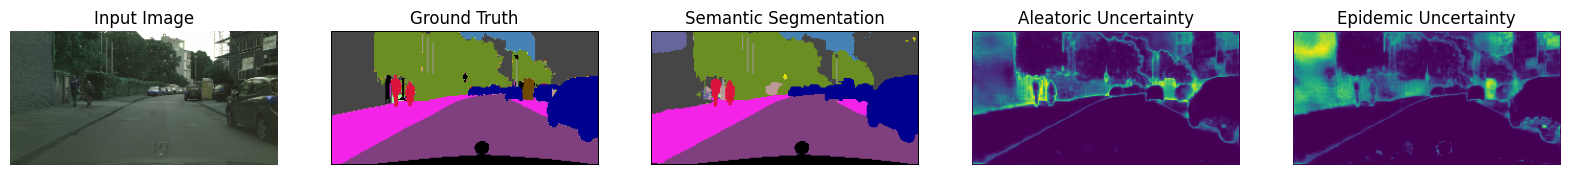

In [16]:
# visualize
for i in range(bs):
    f, ax = plt.subplots(1, 5, figsize=(20,20)) 
    for _ in range(bs):
        ax[_].axis('off')
        
    ax[0].set_title('Input Image') #set titles for each parts
    ax[0].imshow(imgs[i])
    ax[1].set_title('Ground Truth') 
    ax[1].imshow(seg2rgb(trues[i].squeeze(), color_codes)/255.0)
    ax[2].set_title('Semantic Segmentation') 
    ax[2].imshow(seg2rgb(mu[i].squeeze(), color_codes)/255.0)
    ax[3].set_title('Aleatoric Uncertainty')
    ax[3].imshow(aleatoric[i])
    ax[4].set_title('Epidemic Uncertainty')
    ax[4].imshow(episdemic[i])
    
    plt.show()
    